In [11]:
import numpy as np
import networkx as nx
import scipy.sparse.linalg as sla
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd


# 1. Generate a Custom Graph
def generate_graph(n=600, cluster_sizes=[0.3, 0.4, 0.3], intra_prob=0.3, inter_prob=0.05):
    """Generates a stochastic block model graph with user-defined parameters."""
    sizes = list(map(int, [s * n for s in cluster_sizes]))

    # Create probability matrix (strong intra-cluster, weak inter-cluster)
    probs = np.full((len(sizes), len(sizes)), inter_prob)
    np.fill_diagonal(probs, intra_prob)

    G = nx.stochastic_block_model(sizes, probs, seed=42)
    adj_matrix = nx.to_numpy_array(G)

    true_labels = []
    for cluster_id, size in enumerate(sizes):
        true_labels.extend([cluster_id] * size)

    return adj_matrix, np.array(true_labels), G


# 2. Clustering Methods
def normal_clustering(adj_matrix, k):
    X_norm = StandardScaler().fit_transform(adj_matrix)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    return kmeans.fit_predict(X_norm)


def spectral_clustering(adj_matrix, k):
    D = np.diag(np.sum(adj_matrix, axis=1))
    L = D - adj_matrix
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L_sym = D_inv_sqrt @ L @ D_inv_sqrt

    eigvals, eigvecs = np.linalg.eigh(L_sym)
    X = eigvecs[:, :k]
    X_norm = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    return kmeans.fit_predict(X_norm)


def normalized_laplacian(A):
    D = np.diag(np.sum(A, axis=1))
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    return np.eye(len(D)) - D_inv_sqrt @ A @ D_inv_sqrt


def lanczos_eigen(L, k):
    L_sparse = csr_matrix(L)
    eigvals, eigvecs = sla.eigsh(L_sparse, k=k, which='SM')
    return eigvecs


def spectral_clustering_enhanced(A, k):
    L_norm = normalized_laplacian(A)
    X = lanczos_eigen(L_norm, k)
    X_norm = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_norm)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_norm, labels)
    return rf.predict(X_norm)


# 3. Evaluation Functions
def compute_modularity(adj_matrix, labels):
    G = nx.from_numpy_array(adj_matrix)
    return nx.community.modularity(G, [np.where(labels == i)[0] for i in np.unique(labels)])


def compute_conductance(adj_matrix, labels):
    G = nx.from_numpy_array(adj_matrix)
    conductance_values = []
    for cluster in np.unique(labels):
        nodes = np.where(labels == cluster)[0]
        if len(nodes) == 0 or len(nodes) == len(labels):
            continue
        conductance_values.append(nx.algorithms.cuts.conductance(G, nodes))
    return np.mean(conductance_values)


def match_labels(true_labels, pred_labels):
    confusion = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-confusion)
    label_mapping = {pred: true for pred, true in zip(col_ind, row_ind)}
    return np.array([label_mapping.get(pred, pred) for pred in pred_labels])


# 4. Run Experiment
def run_experiment(n=600, cluster_sizes=[0.3, 0.4, 0.3], intra_prob=0.3, inter_prob=0.05):
    """Runs clustering experiments with the given graph parameters."""
    adj_matrix, true_labels, G = generate_graph(n, cluster_sizes, intra_prob, inter_prob)
    k = len(np.unique(true_labels))

    # Apply Clustering Methods
    labels_normal = normal_clustering(adj_matrix, k)
    labels_original = spectral_clustering(adj_matrix, k)
    labels_enhanced = spectral_clustering_enhanced(adj_matrix, k)

    # Correct label mismatches
    labels_normal = match_labels(true_labels, labels_normal)
    labels_original = match_labels(true_labels, labels_original)
    labels_enhanced = match_labels(true_labels, labels_enhanced)

    # Compute Metrics
    metrics = {
        "Silhouette Score": [
            silhouette_score(adj_matrix, labels_normal),
            silhouette_score(adj_matrix, labels_original),
            silhouette_score(adj_matrix, labels_enhanced),
        ],
        "Davies-Bouldin Score": [
            davies_bouldin_score(adj_matrix, labels_normal),
            davies_bouldin_score(adj_matrix, labels_original),
            davies_bouldin_score(adj_matrix, labels_enhanced),
        ],
        "Calinski-Harabasz Index": [
            calinski_harabasz_score(adj_matrix, labels_normal),
            calinski_harabasz_score(adj_matrix, labels_original),
            calinski_harabasz_score(adj_matrix, labels_enhanced),
        ],
        "Adjusted Rand Index": [
            adjusted_rand_score(true_labels, labels_normal),
            adjusted_rand_score(true_labels, labels_original),
            adjusted_rand_score(true_labels, labels_enhanced),
        ],
        "Normalized Mutual Information": [
            normalized_mutual_info_score(true_labels, labels_normal),
            normalized_mutual_info_score(true_labels, labels_original),
            normalized_mutual_info_score(true_labels, labels_enhanced),
        ],
        "Modularity Index": [
            compute_modularity(adj_matrix, labels_normal),
            compute_modularity(adj_matrix, labels_original),
            compute_modularity(adj_matrix, labels_enhanced),
        ],
        "Conductance": [
            compute_conductance(adj_matrix, labels_normal),
            compute_conductance(adj_matrix, labels_original),
            compute_conductance(adj_matrix, labels_enhanced),
        ],
    }

    # Display Metrics in Table
    df_metrics = pd.DataFrame(metrics, index=["Normal KMeans", "Spectral", "Enhanced Spectral"])
    print("\nComparison of Clustering Methods:\n")
    display(df_metrics)

    # Visualize Clusters
    def plot_graph(G, labels, title, ax):
        pos = nx.spring_layout(G, seed=42)
        ax.set_title(title)
        nx.draw(G, pos, node_color=labels, cmap="viridis", with_labels=False, node_size=30, ax=ax)

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    plot_graph(G, true_labels, "True Labels", axes[0, 0])
    plot_graph(G, labels_normal, "Normal Clustering (KMeans)", axes[0, 1])
    plot_graph(G, labels_original, "Spectral Clustering", axes[1, 0])
    plot_graph(G, labels_enhanced, "Enhanced Spectral Clustering", axes[1, 1])

    plt.tight_layout()
    plt.show()


# Example Usage: Run multiple experiments



Comparison of Clustering Methods:



,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Index,Adjusted Rand Index,Normalized Mutual Information,Modularity Index,Conductance
Normal KMeans,0.070958,3.141218,40.951085,1.0,1.0,0.402818,0.254244
Spectral,0.070958,3.141218,40.951085,1.0,1.0,0.402818,0.254244
Enhanced Spectral,0.070958,3.141218,40.951085,1.0,1.0,0.402818,0.254244


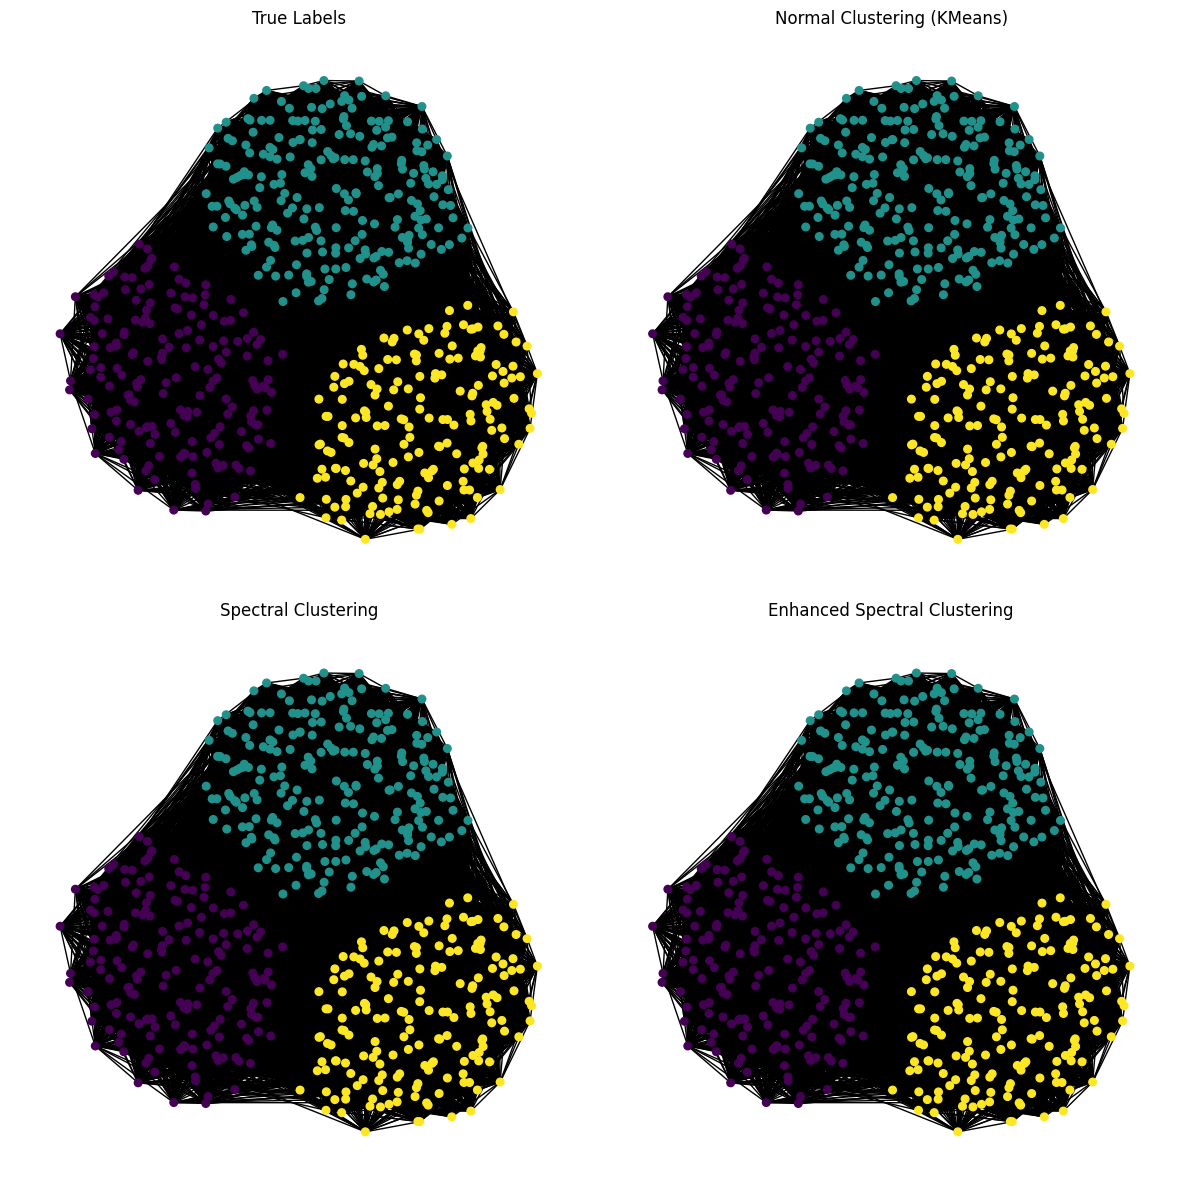

In [12]:
run_experiment(n=600, cluster_sizes=[0.3, 0.4, 0.3], intra_prob=0.3, inter_prob=0.05)


Comparison of Clustering Methods:



,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Index,Adjusted Rand Index,Normalized Mutual Information,Modularity Index,Conductance
Normal KMeans,0.058908,11.746435,36.232254,0.468517,0.650253,0.095543,0.527872
Spectral,-0.004745,3.624894,39.656281,1.000000,1.000000,0.119361,0.557942
Enhanced Spectral,-0.004745,3.624894,39.656281,1.000000,1.000000,0.119361,0.557942


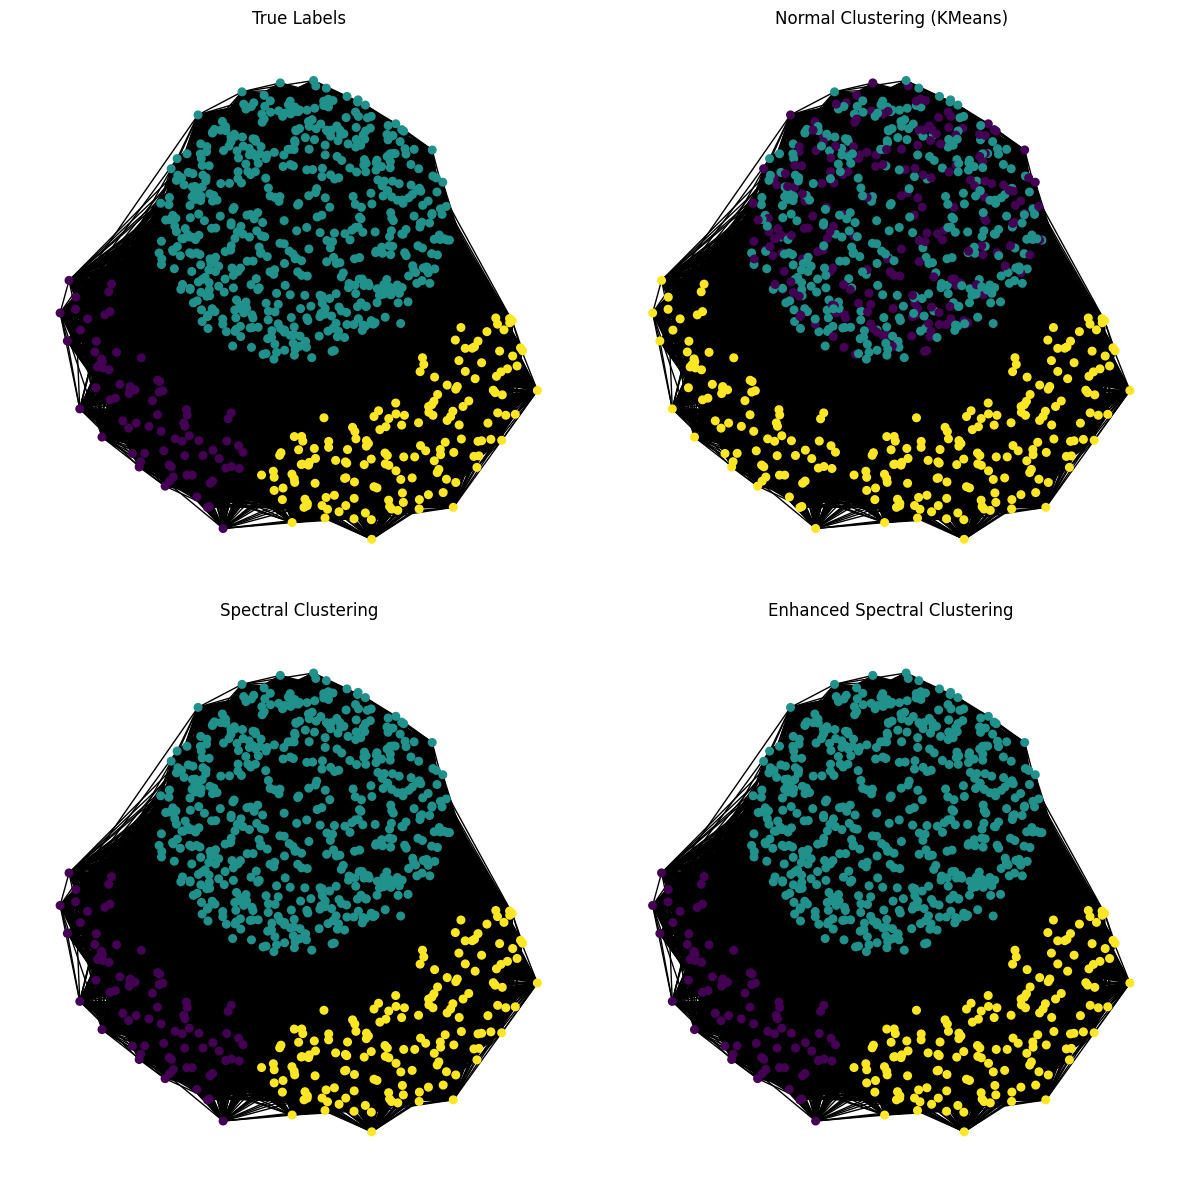

In [13]:
run_experiment(n=800, cluster_sizes=[0.1, 0.7, 0.2], intra_prob=0.4, inter_prob=0.1)